In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from alphavantage_api.AlphaVantageCommodities import AlphaVantageCommodities
from tools.PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [56]:
avc = AlphaVantageCommodities()
df = avc.get_data_as_pandas_df('WTI')

In [58]:
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df,'value')

Text(0.5, 1.0, 'WTI Price')

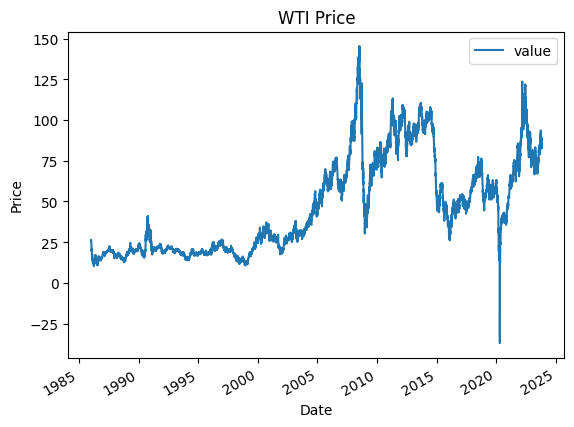

In [5]:
df.plot(x="date", y="value")
plt.xlabel("Date", size=10)
plt.ylabel("Price", size=10)
plt.title("WTI Price")

In [6]:
#df_normalized = avc.get_data_as_pandas_df_normalized('WTI')

Text(0.5, 1.0, 'WTI Price normalized')

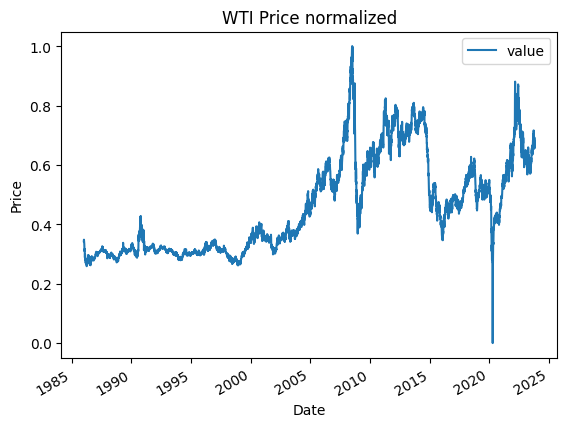

In [59]:
df_normalized.plot(x="date", y="value")
plt.xlabel("Date", size=10)
plt.ylabel("Price", size=10)
plt.title("WTI Price normalized")

In [8]:
data = df_normalized['value'].to_numpy()
data

array([0.6583466 , 0.6748588 , 0.66257066, ..., 0.34840092, 0.34549347,
       0.34307972], dtype=float32)

In [9]:
data.size

9530

In [10]:
left_size = 0.8
split_at = int(left_size * data.size)
data[0:split_at].size

7624

In [11]:
forecasting_label_steps = 10
feature_sequence_length = 100
list_boundaries = forecasting_label_steps+feature_sequence_length

x_train = data[0:split_at]
x_train_data = x_train[:-list_boundaries]
x_train_targets = x_train[list_boundaries:]

x_test = data[split_at+1:]
x_test_data = x_test[:-list_boundaries]
x_test_targets = x_test[list_boundaries:]

In [12]:
len(x_train_data)

7514

In [13]:
len(x_train_targets)

7514

In [14]:
len(x_test_data)

1795

In [15]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=256)

In [16]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=256)

In [17]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 100)
Target shape: (256,)


In [18]:
inputs = keras.layers.Input(shape=(inputs.shape[1], 1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [20]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [21]:
history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 0.0880
Epoch 1: val_loss improved from inf to 0.01218, saving model to model_checkpoint.h5
29/29 [==============================] - 5s 101ms/step - loss: 0.0880 - val_loss: 0.0122
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.0038
Epoch 2: val_loss improved from 0.01218 to 0.00199, saving model to model_checkpoint.h5
29/29 [==============================] - 2s 81ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.0027
Epoch 3: val_loss improved from 0.00199 to 0.00073, saving model to model_checkpoint.h5
29/29 [==============================] - 2s 76ms/step - loss: 0.0027 - val_loss: 7.2788e-04
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss improved from 0.00073 to 0.00026, saving model to model_checkpoint.h5
29/29 [==============================] - 2s 82ms/step - loss: 0.0023 - val_loss: 2.

In [22]:
#x = dataset_test.take(1)

In [47]:
def plot(input_data, predicted_data, output_compare):
    compare_y = list(range(list_boundaries - 1, list_boundaries - 1 + len(output_compare)))
    predicted_y = list(range(feature_sequence_length, feature_sequence_length + len(output_compare)))

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(compare_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length], "rx", label = "start prediction")
    plt.legend()
    plt.show()

8/8 [==============================] - 0s 10ms/step


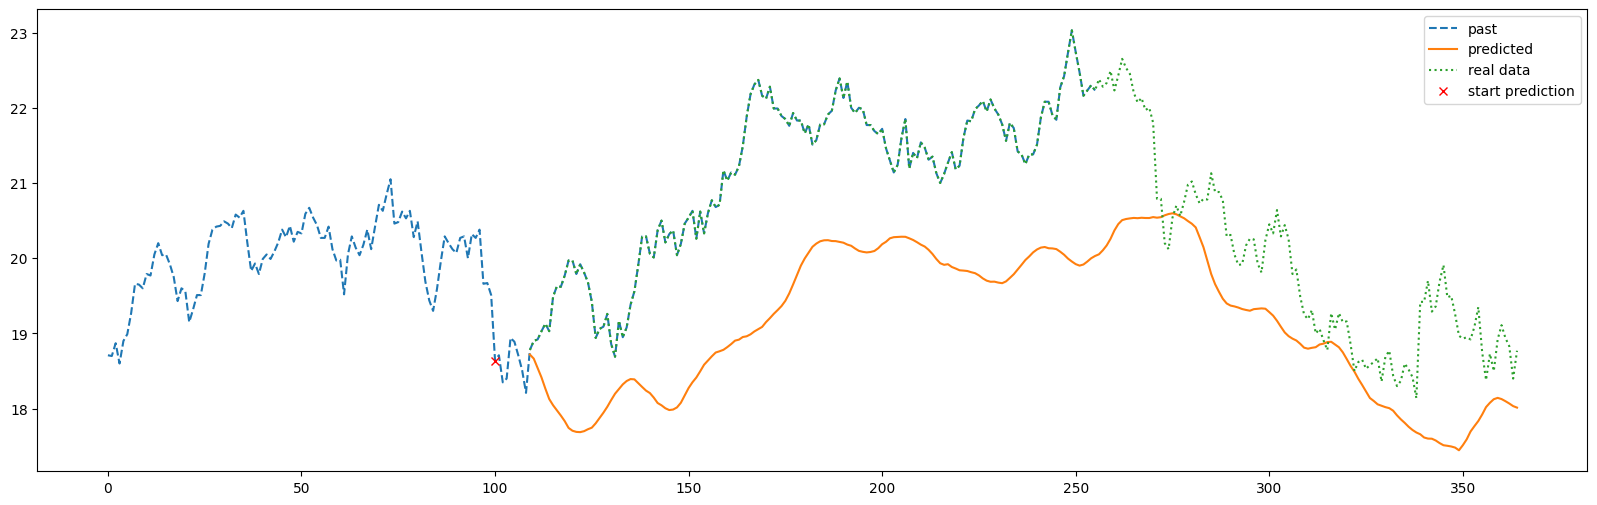

8/8 [==============================] - 0s 9ms/step


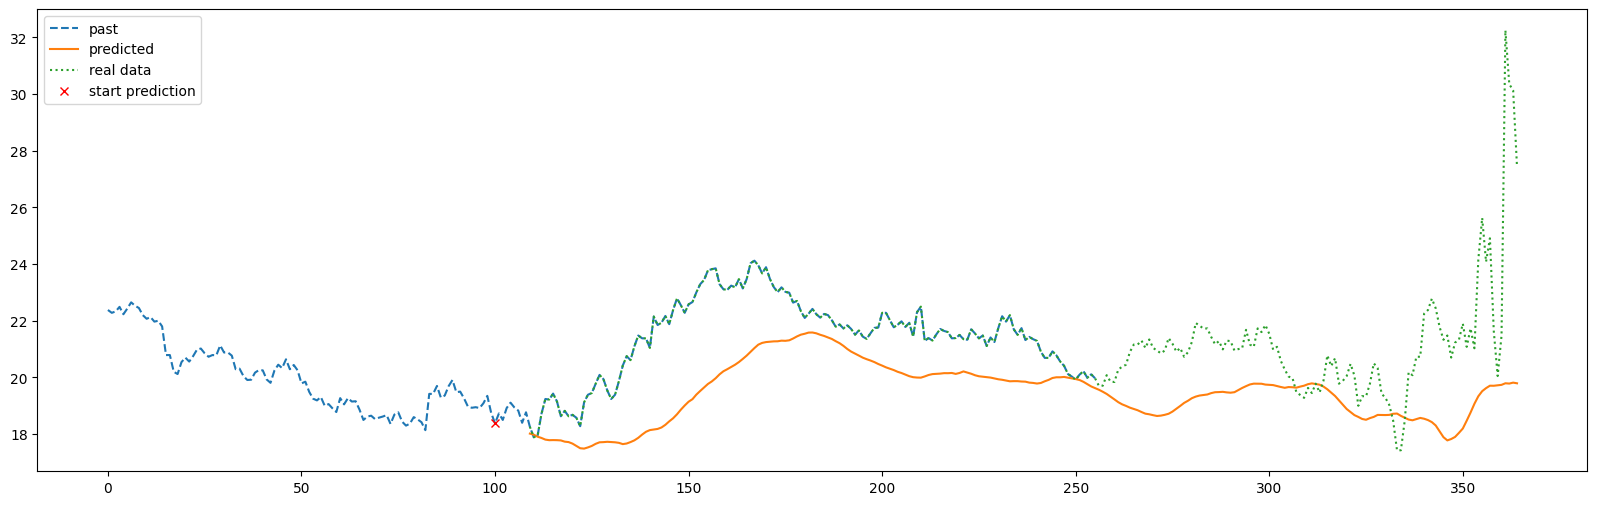

8/8 [==============================] - 0s 9ms/step


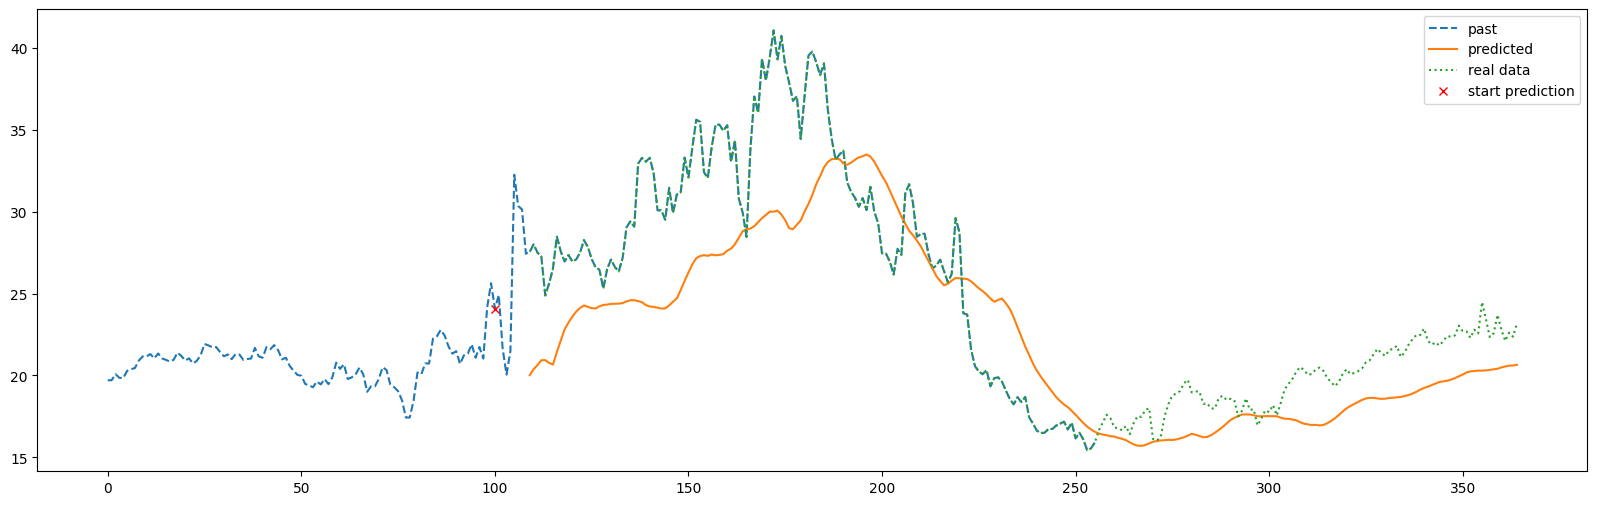

8/8 [==============================] - 0s 10ms/step


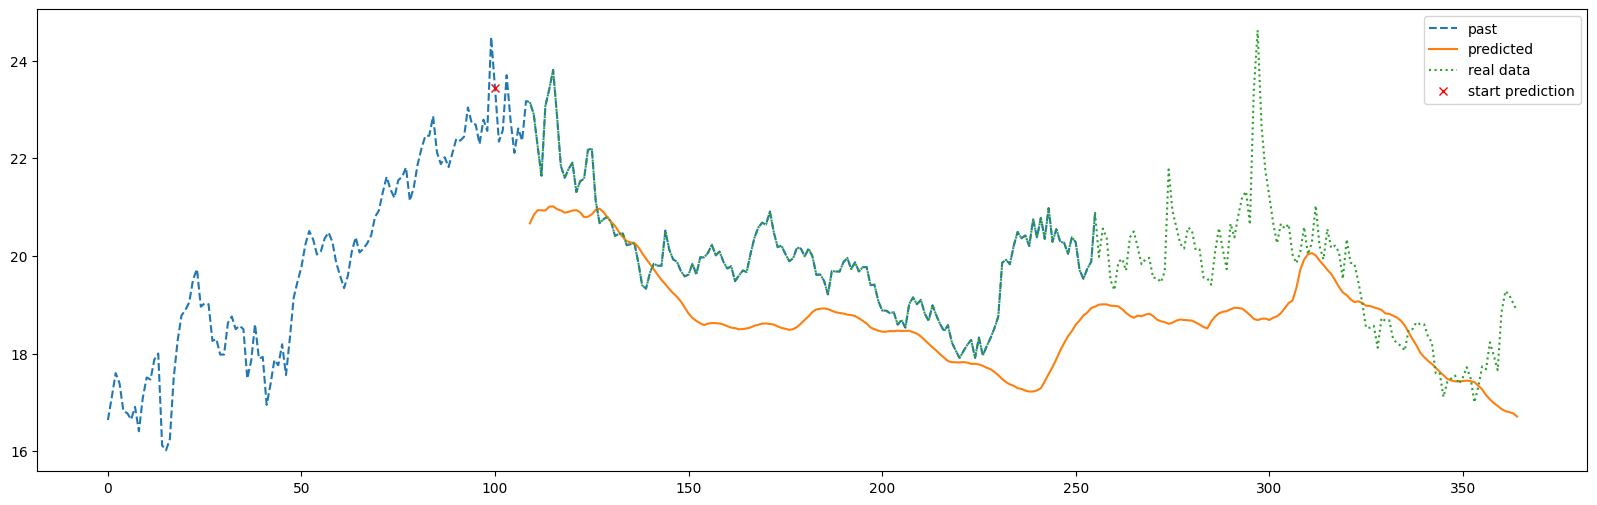

8/8 [==============================] - 0s 10ms/step


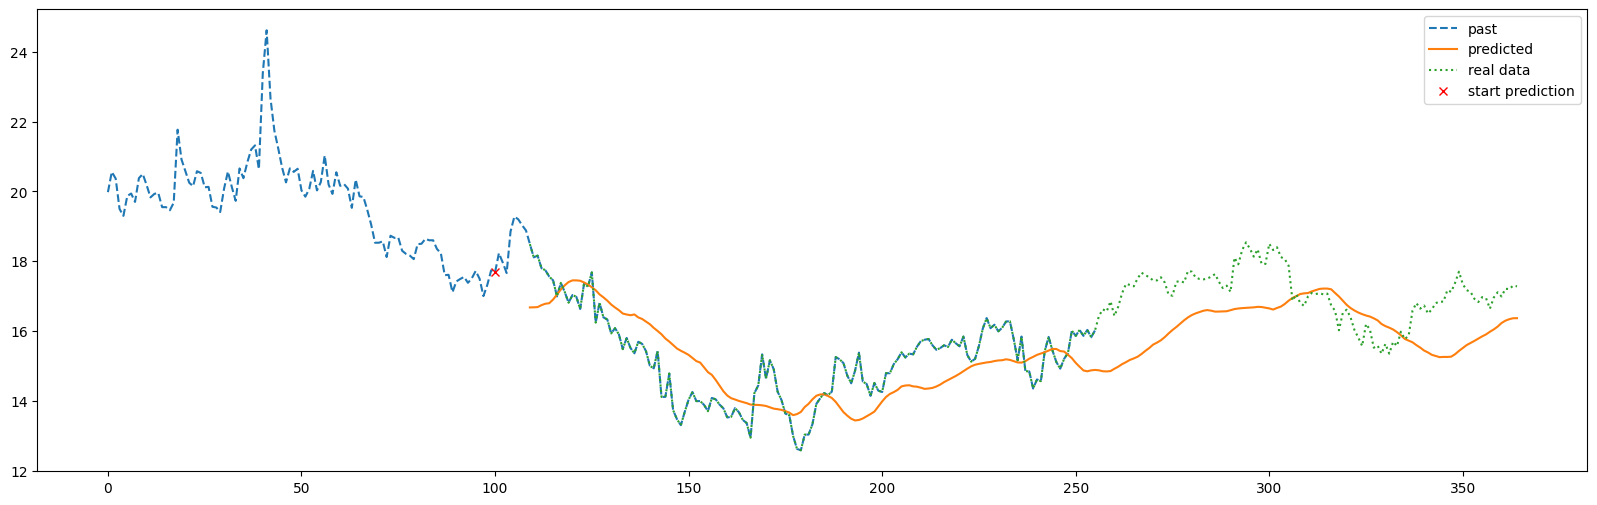

8/8 [==============================] - 0s 10ms/step


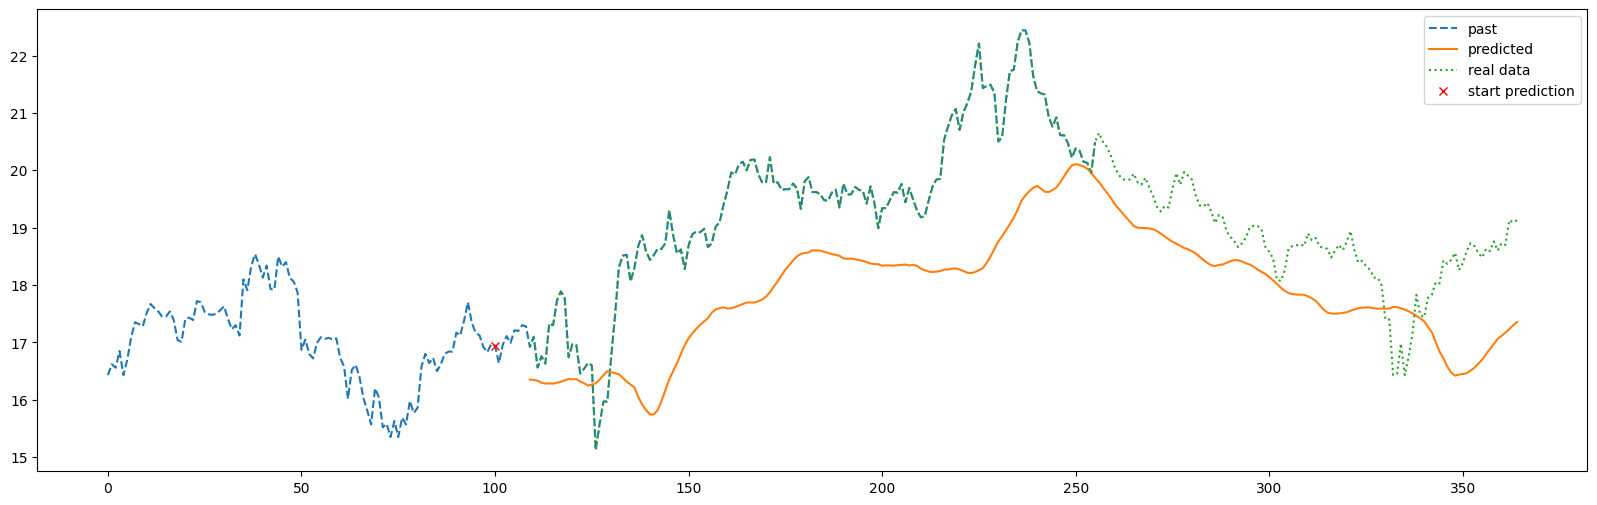

5/5 [==============================] - 0s 10ms/step


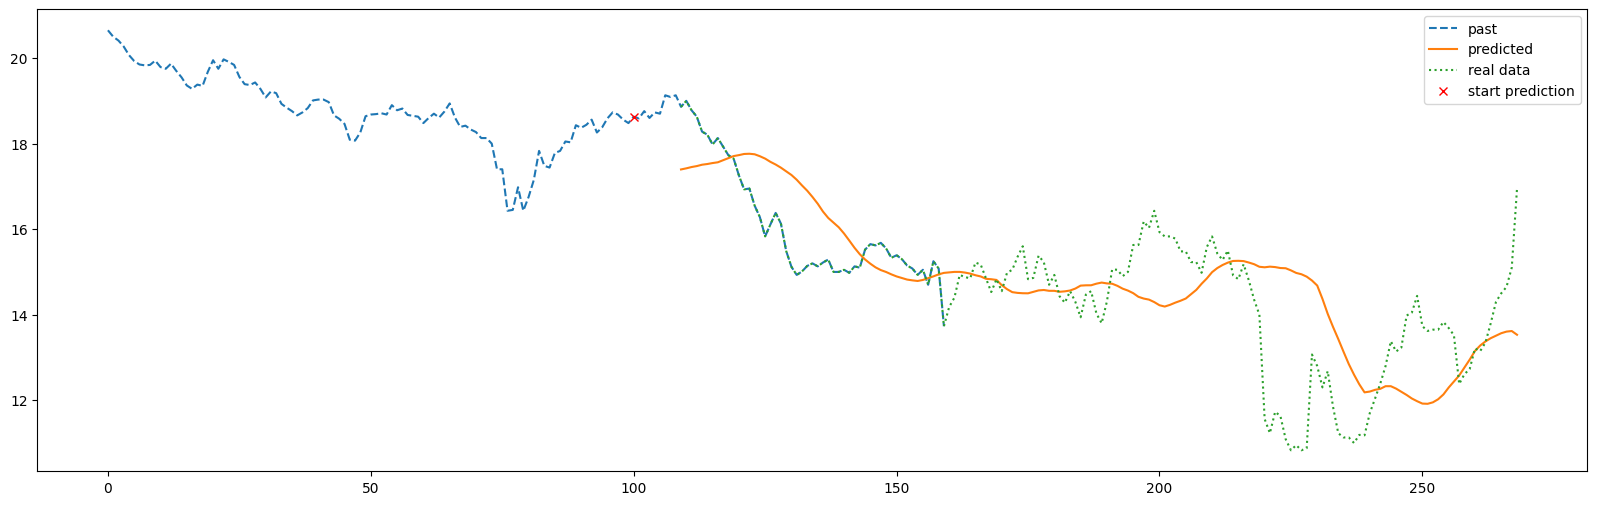

In [62]:
for x, y in dataset_test.take(8):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 1].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [25]:
#input_data = list(x.as_numpy_iterator())[0][0][:, 1]

In [26]:
# output_compare = list(x.as_numpy_iterator())[0][1]

In [27]:
# predicted_data = model.predict(x)

1/1 [==============================] - 1s 785ms/step


In [28]:
# len(predicted_data)

256

In [29]:
#compare_y = list(range(list_boundaries - 1, list_boundaries - 1 + len(output_compare)))
#predicted_y = list(range(feature_sequence_length, feature_sequence_length + len(output_compare)))

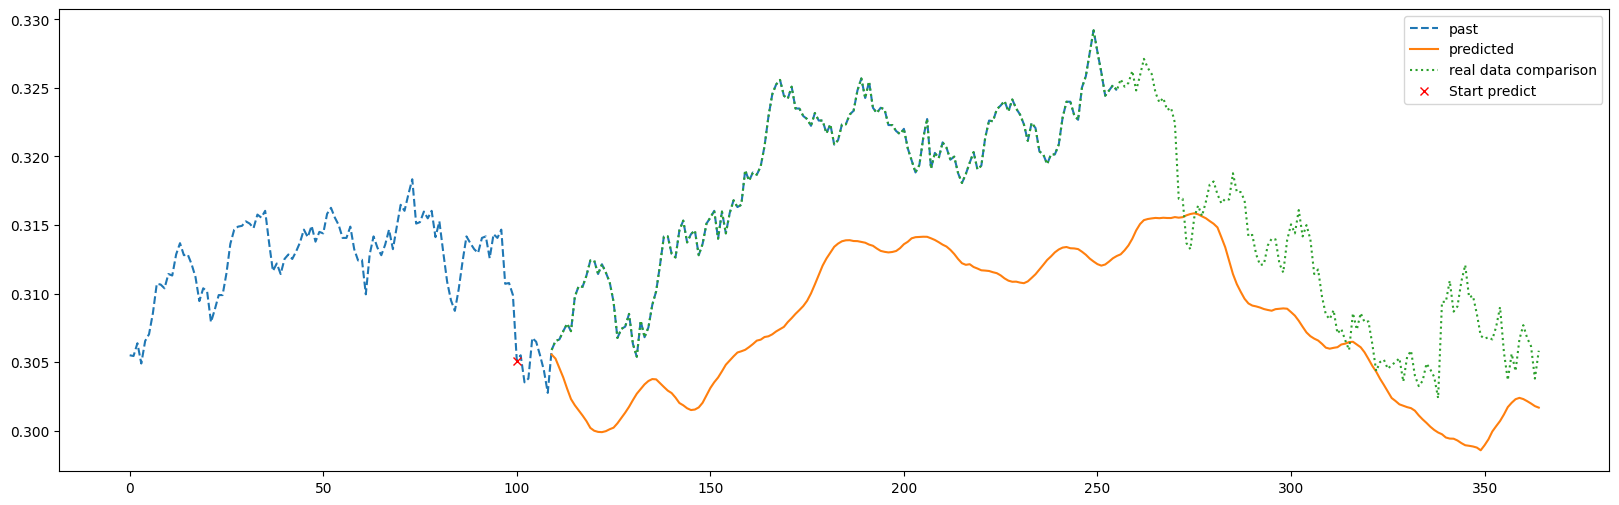

In [30]:
#plt.figure(figsize=(20,6))
#plt.plot(input_data, label = "past", linestyle = 'dashed')
#plt.plot(compare_y, predicted_data, label = "predicted")
#plt.plot(compare_y, output_compare, label = "real data comparison", linestyle = 'dotted')
#plt.plot(feature_sequence_length, input_data[feature_sequence_length], "rx", label = "Start predict")
#plt.legend()
#plt.show()